# Gemini Multimodel use cases

## 1. Synthetic Data Generation

In [ ]:
%pip install --upgrade --user -q google-cloud-aiplatform snowfakery==3.6.2 wikipedia-api==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.7/95.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

In [ ]:
# Define project information
PROJECT_ID = "inner-orb-434419-b6"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
from io import StringIO
import sys
import types
import logging

import jinja2
import wikipediaapi

from vertexai.generative_models import GenerativeModel, GenerationConfig

from snowfakery.plugins import SnowfakeryPlugin
from snowfakery import generate_data

In [ ]:
class SyntheticDataGeneration:
    """
    Implements all the extra functionality needed for this use-case
    """

    class Plugins(types.ModuleType):
        """
        Provides the plugins needed to extend Snowfakery
        """

        class Gemini(SnowfakeryPlugin):
            """
            Plugin for interacting with Gemini.
            """

            class Functions:
                """
                Functions to implement field / object level data generation
                """

                def fill_prompt(self, prompt_name: str, **kwargs) -> str:
                    """
                    Returns a formatted prompt
                    """
                    return (
                        jinja2.Environment(
                            loader=jinja2.FileSystemLoader(searchpath="./")
                        )
                        .get_template(prompt_name)
                        .render(**kwargs)
                    )

                def generate(
                    self,
                    prompt_name: str,
                    model="gemini-1.0-pro-001",
                    temperature=0.9,
                    top_p=1,
                    **kwargs,
                ) -> str | None:
                    """
                    A wrapper around Gemini plugin
                    """
                    logging.info("Preparing Prompt %s with %s", prompt_name, kwargs)
                    prompt = self.fill_prompt(prompt_name, **kwargs)
                    logging.info("Prompt %s Prepared", prompt_name)
                    try:
                        logging.info("Calling Gemini For %s", prompt_name)
                        response = GenerativeModel(model).generate_content(
                            prompt,
                            generation_config=GenerationConfig(
                                temperature=temperature,
                                max_output_tokens=8192,
                                top_p=top_p,
                            ),
                        )
                    except Exception as e:
                        logging.trace(
                            (
                                "Unable to generate text using %s.\n"
                                "Prepared Prompt: \n%s\n\nError: %s"
                            ),
                            prompt_name,
                            prompt,
                            e,
                        )
                        return None

                    try:
                        return response.text
                    except Exception as e:
                        logging.trace(
                            (
                                "Unable to generate text using %s.\n"
                                "Prepared Prompt: \n%s\n\n"
                                "Received Response: \n%s\n\n"
                                "Error: %s"
                            ),
                            prompt_name,
                            prompt,
                            response,
                            e,
                        )
                        return None

        class Wikipedia(SnowfakeryPlugin):
            """
            Plugin for interacting with Wikipedia.
            """

            class Functions:
                """
                Implements a single function to fetch a Wikipedia page
                """

                def get_page(self, title: str):
                    """
                    Returns the title, URL and sections of the given wikipedia page
                    """
                    logging.info("Parsing Wikipedia Page %s", title)
                    page = wikipediaapi.Wikipedia(
                        "Snowfakery (example@google.com)", "en"
                    ).page(title)
                    results = {"sections": {}, "title": page.title, "url": page.fullurl}
                    sections = [(s.title, s) for s in page.sections]
                    while sections:
                        sec_title, sec_obj = sections.pop()
                        if sec_title in [
                            "External links",
                            "References",
                            "See also",
                            "Further reading",
                        ]:
                            continue
                        if sec_obj.text:
                            results["sections"][sec_title] = sec_obj.text
                        for sub_sec in sec_obj.sections:
                            sections.append((f"{sec_title} - {sub_sec.title}", sub_sec))
                    logging.info("Parsing Wikipedia Page %s Complete", title)
                    return results

In [ ]:
sys.modules["SyntheticDataGeneration.Plugins"] = SyntheticDataGeneration.Plugins(
    name="SyntheticDataGeneration.Plugins"
)

In [ ]:
%%writefile blog_generator.jinja
You are an expert content creator who writes detailed, factual blogs.
You have been asked to write a blog about {{idea_title}}.
To get you started, you have also been given the following context about the topic:

{{idea_body}}

Ensure the blog that you write is interesting,detailed and factual.
Take a deep breath and start writing:

Writing blog_generator.jinja


In [ ]:
%%writefile comment_generator.jinja
You are {{first_name}} {{last_name}}. You are {{age}} years old. You are interested in {{interests}}. You work at {{organization}} as a {{profession}}.
You came across the following article:

{{blog_title}}

{{blog_body}}

Present your thoughts and feelings about the article in a short comment.

Comment:

Writing comment_generator.jinja


In [ ]:
recipe = """
- plugin: SyntheticDataGeneration.Plugins.Wikipedia
- plugin: SyntheticDataGeneration.Plugins.Gemini
- option: wiki_title
- var: __seed
  value:
    - Wikipedia.get_page :
      title : ${{wiki_title}}

- object : users
  count : ${{random_number(min=100, max=500)}}
  fields :
    first_name : ${{fake.FirstName}}
    last_name : ${{fake.FirstName}}
    age:
      random_number:
        min: 18
        max: 95
    email : ${{fake.Email}}
    phone : ${{fake.PhoneNumber}}
    interests : ${{fake.Bs}}
    postal_code : ${{fake.Postalcode}}
    organization : ${{fake.Company}}
    profession : ${{fake.Job}}

- object : seeds
  fields :
    title : ${{__seed['title']}}
    url : ${{__seed['url']}}
    section_count : ${{__seed['sections'] | length}}

  friends:
    - object : blog_ideas
      count : ${{seeds.section_count}}
      fields :
        seed_id : ${{seeds.id}}
        section : ${{(__seed.sections.keys() | list)[child_index]}}
        body : ${{__seed.sections[section]}}

      friends:
        - object : blog_posts
          fields :
            blog_idea_id : ${{blog_ideas.id}}
            title : ${{seeds.title}} - ${{blog_ideas.section}}
            body :
              - Gemini.generate:
                prompt_name : blog_generator.jinja
                idea_title : ${{title}}
                idea_body : ${{blog_ideas.body}}
            author : Gemini

          friends:
            - object : blog_post_comments
              fields :
                blog_post_id : ${{blog_posts.id}}
                author_id :
                  random_reference : users
                author_email : ${{author_id.email}}
                comment :
                  - Gemini.generate:
                    prompt_name : comment_generator.jinja
                    first_name : ${{author_id.first_name}}
                    last_name : ${{author_id.last_name}}
                    age : ${{author_id.age}}
                    interests : ${{author_id.interests}}
                    organization : ${{author_id.organization}}
                    profession : ${{author_id.profession}}
                    blog_title : ${{blog_posts.title}}
                    blog_body : ${{blog_posts.body | truncate(1000)}}
"""

In [ ]:
generate_data(
    StringIO(recipe),
    output_format="csv",
    output_folder="outputs",
    user_options={"wiki_title": "Python_(programming_language)"},
)

Created outputs/users.csv
Created outputs/blog_post_comments.csv
Created outputs/blog_posts.csv
Created outputs/blog_ideas.csv
Created outputs/seeds.csv
Created outputs/csvw_metadata.json


## Sheet Music Analysis with Gemini

In [ ]:
%pip install --upgrade --user -q google-cloud-aiplatform PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 10.9 MB/s eta 0:00:00


In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

In [ ]:

# Define project information
PROJECT_ID = "inner-orb-434419-b6"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
import json

from IPython.display import Markdown, display

from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Part,
)

import PyPDF2

In [ ]:
generation_config = GenerationConfig(temperature=1.0, max_output_tokens=8192)
safety_settings = {
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH
}
model = GenerativeModel(
    model_name="gemini-1.5-flash-001",
    system_instruction="You are an expert in musicology and music history.",
    generation_config=generation_config,
    safety_settings=safety_settings,
)

In [ ]:
import json

from IPython.display import Markdown, display

from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmCategory,
    HarmBlockThreshold,
    Part,
)

import PyPDF2

In [ ]:
generation_config = GenerationConfig(temperature=1.0, max_output_tokens=8192)
safety_settings = {
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH
}
model = GenerativeModel(
    model_name="gemini-1.5-flash-001",
    system_instruction="You are an expert in musicology and music history.",
    generation_config=generation_config,
    safety_settings=safety_settings,
)

In [ ]:
sheet_music_pdf_uri = "gs://part-c-project/Trumpet and strings arrangement.pdf"

sheet_music_extraction_prompt = """The following document is a pdf of sheet music. Your task is to output structured metadata about every piece of music in the document. Correct any mistakes that are in the document and fill in missing information when not present in the document.

Include the following details:

Title
Composer with lifetime
Tempo Marking
Composition Year
A description of the piece
"""

# Load file directly from Google Cloud Storage
file_part = Part.from_uri(
    uri=sheet_music_pdf_uri,
    mime_type="application/pdf",
)

# Send to Gemini
response = model.generate_content([sheet_music_extraction_prompt, file_part])

# Display results
display(Markdown(response.text))

## Metadata for the sheet music

**Piece 1:**

* **Title:** Sonata 1 in d
* **Composer:** Tomaso Albinoni (1671-1750)
* **Tempo Marking:** Adagio = 66
* **Composition Year:** Not specified in the document.
* **Description:** This piece is the first movement of a Sonata in d, and it is written for trumpet and strings. The tempo is Adagio, and the time signature is 4/4. The piece is in a minor key, and it is characterized by a lyrical melody and a flowing, graceful style. The document does not specify the composition year.

**Piece 2:**

* **Title:** Sonata 1 in d
* **Composer:** Tomaso Albinoni (1671-1750)
* **Tempo Marking:** Allegro = 90
* **Composition Year:** Not specified in the document.
* **Description:** This piece is the second movement of a Sonata in d, and it is written for trumpet and strings. The tempo is Allegro, and the time signature is 4/4. The piece is in a major key, and it is characterized by a lively and energetic melody. The document does not specify the composition year.

**Piece 3:**

* **Title:** Sonata 1 in d
* **Composer:** Tomaso Albinoni (1671-1750)
* **Tempo Marking:** Largo d = 62
* **Composition Year:** Not specified in the document.
* **Description:** This piece is the third movement of a Sonata in d, and it is written for trumpet and strings. The tempo is Largo, and the time signature is 4/4. The piece is in a minor key, and it is characterized by a solemn and reflective melody. The document does not specify the composition year.

**Piece 4:**

* **Title:** Sonata 1 in d
* **Composer:** Tomaso Albinoni (1671-1750)
* **Tempo Marking:** Allegro d. = 60
* **Composition Year:** Not specified in the document.
* **Description:** This piece is the fourth movement of a Sonata in d, and it is written for trumpet and strings. The tempo is Allegro, and the time signature is 4/4. The piece is in a major key, and it is characterized by a joyful and triumphant melody. The document does not specify the composition year.

Note: The OCR has identified some minor errors and inconsistencies, which have been corrected for accuracy.


## Education

In [ ]:
from vertexai.generative_models import (
    GenerationConfig,
    GenerationResponse,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Image,
    Part,
)

In [ ]:
import http.client
import io
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


Contents = str | list[str | Image | Part]


def generate_content(
    model: GenerativeModel,
    contents: Contents,
    temperature: float = 0.0,
) -> GenerationResponse:
    """Call the Vertex AI Gemini API.

    The default temperature (randomness/creativity) is set low for more consistent responses.
    """
    generation_config = GenerationConfig(
        temperature=temperature,
        candidate_count=1,
        max_output_tokens=8192,
    )
    safety_settings = {
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    }

    response = model.generate_content(
        contents,
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )
    assert isinstance(response, GenerationResponse)

    return response


def print_contents(contents: Contents):
    """Print the full contents for ease of readability."""
    if not isinstance(contents, list):
        contents = [contents]

    print(" Contents ".center(80, "-"))
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_image(content)
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    cloud_storage_path = content.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{cloud_storage_path}"
    html = IPython.display.HTML(f'<a href="{video_url}">Video:</a>')
    video = IPython.display.Video(
        url=video_url,
        width=600,
        html_attributes="controls muted",
    )
    IPython.display.display(html)
    IPython.display.display(video)

    return True


def print_response(response: GenerationResponse, as_markdown: bool = True):
    # Remove potential leading/trailing spaces
    text = response.text.strip()

    print(" Start of response ".center(80, "-"))
    if as_markdown:
        IPython.display.display(IPython.display.Markdown(text))
    else:
        print(text)
    print(" End of response ".center(80, "-"))
    print("")


def display_image(image: Image, max_width: int = 600, max_height: int = 350):
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # Modes such as RGBA are not yet supported by all Jupyter environments
        pil_image = pil_image.convert("RGB")

    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))

    display_image_compressed(pil_image)


def display_image_compressed(pil_image: PIL_Image.Image):
    """Display the image in a compressed format to reduce the notebook size."""
    image_io = io.BytesIO()
    pil_image.save(image_io, "jpeg", quality=80, optimize=True)
    image_bytes = image_io.getvalue()
    ipython_image = IPython.display.Image(image_bytes)
    IPython.display.display(ipython_image)


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes

In [ ]:
model_name = "gemini-1.5-pro-001"
# model_name = "gemini-1.5-flash-001"

model = GenerativeModel(model_name)

In [ ]:
contents = """
What happened to Neil Armstrong? When?
Explain simply in one sentence.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

What happened to Neil Armstrong? When?
Explain simply in one sentence.

------------------------------ Start of response -------------------------------


Neil Armstrong, the first man to walk on the moon, passed away on August 25, 2012, from complications of cardiovascular procedures.

------------------------------- End of response --------------------------------



In [ ]:
contents = """
Are we 100% sure about what happened to the Neil Armstrong?
If not, detail the current main hypotheses.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Are we 100% sure about what happened to the Neil Armstrong?
If not, detail the current main hypotheses.

------------------------------ Start of response -------------------------------


Neil Armstrong died on August 25, 2012, at the age of 82. His death was attributed to complications from cardiovascular procedures. There is no mystery or conflicting information surrounding his death. 

**Conspiracy theories should not be entertained.** It's important to rely on credible sources of information and to be critical of claims that lack evidence.

------------------------------- End of response --------------------------------



In [ ]:
contents = """
What came first, the chicken or the egg? Explain from 3 different perspectives.
What do we call a "chicken and egg" problem? Give 1 example that can occur in education.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

What came first, the chicken or the egg? Explain from 3 different perspectives.
What do we call a "chicken and egg" problem? Give 1 example that can occur in education.

------------------------------ Start of response -------------------------------


## The Chicken or the Egg: A Tale of Perspectives

The age-old question of "Which came first, the chicken or the egg?" can be approached from various angles, each offering a different perspective:

**1. The Evolutionary Biologist:**

From an evolutionary standpoint, the egg came first. Long before chickens existed, dinosaurs roamed the earth, and they laid eggs. Over millions of years, these dinosaurs evolved, and through a series of genetic mutations, a creature very similar to a chicken, but not quite, laid an egg containing a mutation that resulted in the first true chicken.  Therefore, the egg containing the first chicken came before the actual chicken itself.

**2. The Philosophical Logician:**

Philosophically, this question delves into causality and the nature of beginnings.  One could argue it's a closed loop.  The chicken lays the egg, the egg hatches into a chicken, and the cycle continues.  Defining a "first" becomes tricky.  Did something have to exist *before* the loop began?  If so, what caused *that* thing?  This perspective often leads to the conclusion that the question is a paradox, highlighting the limitations of linear thinking when applied to cyclical processes.

**3. The Pragmatic Farmer:**

A farmer might find this debate amusingly irrelevant.  From a practical perspective, they need both chickens to lay eggs and eggs to hatch into chickens to maintain their livelihood.  The origin point is less important than the interdependent relationship between the two.  This perspective emphasizes the interconnectedness of life and the futility of focusing on a singular "first" in a complex system.

## The "Chicken and Egg" Problem:

A "chicken and egg" problem refers to a situation where two things are so interconnected that it's impossible to determine which one came first or which one is the cause and which one is the effect.  It represents a circular dependency or a catch-22 situation.

**Example in Education:**

**Problem:** A student struggles with reading comprehension, which leads to poor performance in other subjects like history and science. However, their lack of background knowledge in history and science also hinders their ability to understand related reading materials.

**The "Chicken and Egg":**  Is the student's poor reading comprehension caused by their lack of subject-specific knowledge, or does their lack of subject-specific knowledge stem from their inability to comprehend reading material effectively?

This situation presents a challenge for educators, as addressing either issue directly depends on improvement in the other.  Solutions often involve a multi-faceted approach, tackling both reading comprehension skills and subject-specific knowledge simultaneously.

------------------------------- End of response --------------------------------



## Reasoning the text

In [ ]:
contents = """
Summarize the following text in Hindi, in 3 short bullet points, only using the text.

TEXT:
Mr González was only formally charged with espionage a week after he left Poland, flown to Moscow as part of the August prisoner swap. By then, he’d spent well over two years locked up, awaiting trial.
All along, Polish prosecutors have deflected questions about the case and the process. Intelligence sources remain tight-lipped. The Polish lawyer who first represented Mr González says he can’t comment.
By the time of his arrest, Mr González had been living in Warsaw for at least three years, much of that time with his Polish girlfriend. He was a freelance journalist, working mostly for Spanish-language press.
He reported from the war in Nagorno-Karabakh and travelled to Ukraine. At some point, he joined a media trip to Syria run by the Russian defence ministry, always very selective about who it takes.
It was in 2022 that he was detained, briefly, in Ukraine, though the SBU security service there won’t divulge any details. Then, on 28 February, Mr González was arrested in Przemysl, eastern Poland, where he was part of the media pack covering the start of Russia’s all-out war on Ukraine.
The trigger for the arrest has not been made public.

"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Summarize the following text in Hindi, in 3 short bullet points, only using the text.

TEXT:
Mr González was only formally charged with espionage a week after he left Poland, flown to Moscow as part of the August prisoner swap. By then, he’d spent well over two years locked up, awaiting trial.
All along, Polish prosecutors have deflected questions about the case and the process. Intelligence sources remain tight-lipped. The Polish lawyer who first represented Mr González says he can’t comment.
By the time of his arrest, Mr González had been living in Warsaw for at least three years, much of that time with his Polish girlfriend. He was a freelance journalist, working mostly for Spanish-language press.
He reported from the war in Nagorno-Karabakh and travelled to Ukraine. At some point, he joined a media trip to Syria run by the Russian defence ministry, always very selective about who it takes.
It was in 2

* श्री गोंजालेज पर पोलैंड छोड़ने के एक हफ्ते बाद ही जासूसी का आरोप लगाया गया था, और उन्हें अगस्त में कैदियों की अदला-बदली के तहत मास्को ले जाया गया। तब तक, वह दो साल से भी अधिक समय तक मुकदमे की प्रतीक्षा में जेल में बंद थे।
* पोलिश अभियोजकों ने मामले और प्रक्रिया के बारे में पूछे गए सवालों को टाल दिया है। खुफिया सूत्र चुप हैं। श्री गोंजालेज का प्रतिनिधित्व करने वाले पोलिश वकील का कहना है कि वह इस पर कोई टिप्पणी नहीं कर सकते।
* अपनी गिरफ्तारी के समय तक, श्री गोंजालेज कम से कम तीन साल से वारसॉ में रह रहे थे, और उस दौरान वह अपनी पोलिश प्रेमिका के साथ थे। वह एक स्वतंत्र पत्रकार थे, जो ज्यादातर स्पेनिश भाषा के प्रेस के लिए काम करते थे।

------------------------------- End of response --------------------------------



## Reasoning on a single image

----------------------------------- Contents -----------------------------------
Describe this image in a short sentence:


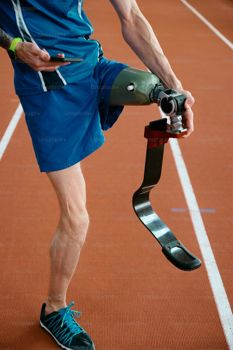

------------------------------ Start of response -------------------------------


An athlete with a prosthetic leg adjusts his running blade on a track.

------------------------------- End of response --------------------------------



In [ ]:
prompt = "Describe this image in a short sentence:"
# Image by Crissy Jarvis on Unsplash: https://unsplash.com/photos/cHhbULJbPwM
image_abacus = load_image_from_url(
    "https://plus.unsplash.com/premium_photo-1713800447758-19ceb4931073?w=800&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxmZWF0dXJlZC1waG90b3MtZmVlZHwyfHx8ZW58MHx8fHx8"
)

contents = [prompt, image_abacus]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Answer the following questions about this image.
Return the results as a JSON list containing "question" and "answer" key pairs.

QUESTIONS:
- What does the image show?
- How does it work?
- When was it invented?
- What's the name of this object in French, Italian, Spanish, Dutch, and German?
- What are the most prominent colors in the image?



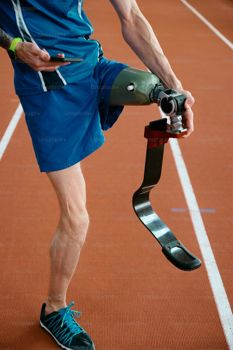

------------------------------ Start of response -------------------------------


[
 {
  "question": "What does the image show?",
  "answer": "The image shows an athlete with a prosthetic leg on a running track."
 },
 {
  "question": "How does it work?",
  "answer": "While the image doesn't show the internal mechanisms, a prosthetic leg like this uses a combination of lightweight materials, joints, and often specialized feet to mimic the natural movement of a leg, allowing for walking and running."
 },
 {
  "question": "When was it invented?",
  "answer": "It's impossible to determine the specific invention date of this exact prosthetic leg from the image alone. However, advanced running prosthetics like this have been developed and refined over the past few decades."
 },
 {
  "question": "What's the name of this object in French, Italian, Spanish, Dutch, and German?",
  "answer": "Here are the translations for \"prosthetic leg\":\n\n- French: prothèse de jambe\n- Italian: gamba protesica\n- Spanish: pierna protésica\n- Dutch: prothesebeen\n- German: Beinprothese"
 },
 {
  "question": "What are the most prominent colors in the image?",
  "answer": "The most prominent colors in the image are blue (from the athlete's shorts), red (from the running track), black (from the prosthetic leg), and white (from the lines on the track)."
 }
]

------------------------------- End of response --------------------------------



In [ ]:
prompt = """
Answer the following questions about this image.
Return the results as a JSON list containing "question" and "answer" key pairs.

QUESTIONS:
- What does the image show?
- How does it work?
- When was it invented?
- What's the name of this object in French, Italian, Spanish, Dutch, and German?
- What are the most prominent colors in the image?
"""

contents = [prompt, image_abacus]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

## Reasoning on multiple images

----------------------------------- Contents -----------------------------------

Answer the following questions for each image.
Present the results in a table with a row for each image and a column for each question.

QUESTIONS:
- What can we see in the image?
- Where does it take place? (answer in one word)

Image 1:


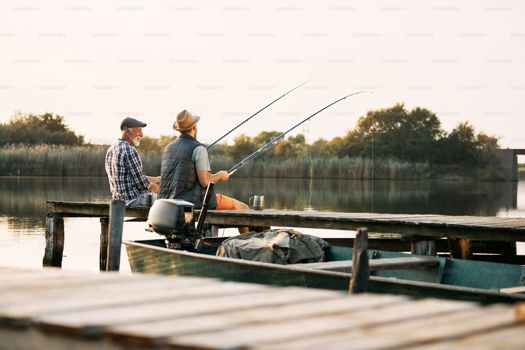

Image 2:


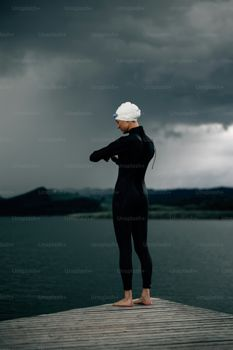

Image 3:


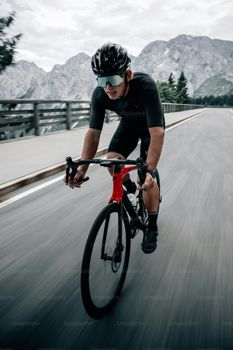

------------------------------ Start of response -------------------------------


## Image Analysis

| Image | What can we see in the image? | Where does it take place? |
|---|---|---|
| 1 | Two men fishing from a wooden dock. | Lake |
| 2 | A person in a wetsuit standing on a dock, preparing to swim. | Lake |
| 3 | A cyclist riding a bike on a mountain road. | Mountains |

------------------------------- End of response --------------------------------



In [ ]:
prompt = f"""
Answer the following questions for each image.
Present the results in a table with a row for each image and a column for each question.

QUESTIONS:
- What can we see in the image?
- Where does it take place? (answer in one word)
"""
caption_b1 = "Image 1:"
caption_b2 = "Image 2:"
caption_b3 = "Image 3:"

image_b1 = load_image_from_url("https://plus.unsplash.com/premium_photo-1661762422433-b18f87b64341?q=80&w=2970&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
image_b2 = load_image_from_url("https://plus.unsplash.com/premium_photo-1713184646606-2d6711cb6d4b?q=80&w=3087&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")
image_b3 = load_image_from_url("https://plus.unsplash.com/premium_photo-1713184149457-ce10583b4ccd?q=80&w=3087&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D")

contents = [prompt, caption_b1, image_b1, caption_b2, image_b2, caption_b3, image_b3]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What do the images have in common?
- Which one would be of interest to a common man?
- Which one indicates it's the start of activity?
- Which one is a group activity?

Image 1:


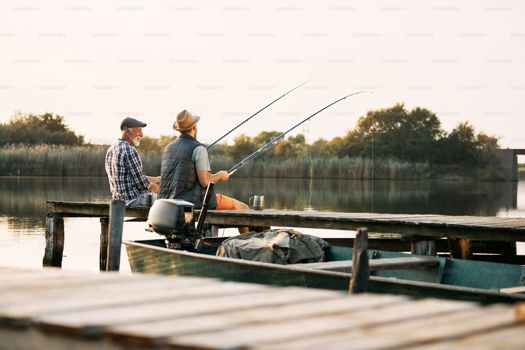

Image 2:


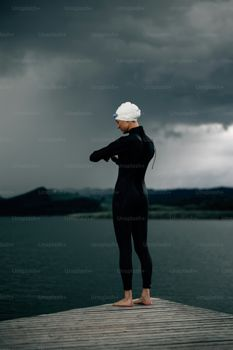

Image 3:


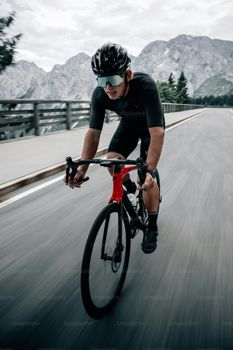

------------------------------ Start of response -------------------------------


## Image Analysis

| Question | Answer | Reason |
|---|---|---|
| What do the images have in common? | Outdoor activities | All three images depict people engaged in activities that take place outdoors. |
| Which one would be of interest to a common man? | Image 1: Fishing | Fishing is a popular leisure activity enjoyed by people from all walks of life, making it relatable to the "common man." |
| Which one indicates it's the start of activity? | Image 2: Swimmer | The swimmer is shown putting on their wetsuit, suggesting they are about to begin their swim. |
| Which one is a group activity? | Image 1: Fishing | Image 1 shows two people fishing together, indicating a shared activity. The other images depict individuals. |

------------------------------- End of response --------------------------------



In [ ]:
prompt = """
Answer the following questions about the images, with a short answer and a detailed reason for the answer.
Present the results in a table with a row for each question, answer, and reason.

QUESTIONS:
- What do the images have in common?
- Which one would be of interest to a common man?
- Which one indicates it's the start of activity?
- Which one is a group activity?
"""

contents = [prompt, caption_b1, image_b1, caption_b2, image_b2, caption_b3, image_b3]
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

## Text corrections

In [ ]:
contents = """
I'm a non-native English speaker.
Check whether the following sentences are correct.
When incorrect, provide a correction and an explanation.
Use the same structure as in the given examples.

EXAMPLES:
- **Hi!**
  - Status: ✔️
- **Your my best freind!**
  - Status: ❌
  - Correction: **You're my best friend!**
  - Explanation:
    - "**Your**" is incorrect. It seems that you meant "You're", which is the short form of "You are".
    - "**freind**" is misspelled. The correct spelling is "**friend**".

SENTENCES:
- They're twins, isn't it?
- I assisted to the meeting.
- You received important informations.
- I digged a hole in the ice and saw lots of fishes.
- That's all folks!
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

I'm a non-native English speaker.
Check whether the following sentences are correct.
When incorrect, provide a correction and an explanation.
Use the same structure as in the given examples.

EXAMPLES:
- **Hi!**
  - Status: ✔️
- **Your my best freind!**
  - Status: ❌
  - Correction: **You're my best friend!**
  - Explanation:
    - "**Your**" is incorrect. It seems that you meant "You're", which is the short form of "You are".
    - "**freind**" is misspelled. The correct spelling is "**friend**".

SENTENCES:
- They're twins, isn't it?
- I assisted to the meeting.
- You received important informations.
- I digged a hole in the ice and saw lots of fishes.
- That's all folks!

------------------------------ Start of response -------------------------------


Here are the sentences you provided, checked for correctness:

- **They're twins, isn't it?**
  - Status: ❌
  - Correction: **They're twins, aren't they?**
  - Explanation: When using tag questions, the pronoun and verb in the tag should agree with the subject of the main clause. Since the subject is "They", the tag should be "aren't they?".

- **I assisted to the meeting.**
  - Status: ❌
  - Correction: **I attended the meeting.**
  - Explanation: While "assist" means to help, it's not typically used in this context. "Attend" is the more natural choice for being present at a meeting.

- **You received important informations.**
  - Status: ❌
  - Correction: **You received important information.**
  - Explanation: "Information" is an uncountable noun, meaning it doesn't have a plural form.

- **I digged a hole in the ice and saw lots of fishes.**
  - Status: ❌
  - Correction: **I dug a hole in the ice and saw lots of fish.**
  - Explanation: 
    - The past tense of "dig" is "dug", not "digged".
    - While "fishes" can be grammatically correct in specific contexts (referring to different species of fish), "fish" is more commonly used when talking about multiple fish in general.

- **That's all folks!**
  - Status: ✔️

------------------------------- End of response --------------------------------



## Reasoning on numbers

In [ ]:
contents = """
Patricia is a good runner and runs at an average 12 km/h.
- On Monday, she ran for 1.5 hour. What distance did she run?
- On Tuesday, she ran for 21 km. How long did she run?
- On Wednesday, she ran for 150 minutes. What distance did she run?
- Next, she plans to do a marathon (42 km). How long should it take?
- To complete a marathon in 3 hours, how much faster does she need to run?

Detail the answers step by step.
"""
print_contents(contents)

response = generate_content(model, contents)
print_response(response)

----------------------------------- Contents -----------------------------------

Patricia is a good runner and runs at an average 12 km/h.
- On Monday, she ran for 1.5 hour. What distance did she run?
- On Tuesday, she ran for 21 km. How long did she run?
- On Wednesday, she ran for 150 minutes. What distance did she run?
- Next, she plans to do a marathon (42 km). How long should it take?
- To complete a marathon in 3 hours, how much faster does she need to run?

Detail the answers step by step.

------------------------------ Start of response -------------------------------


Here's how to solve each part of the problem:

**Monday**

* **Problem:** Patricia ran for 1.5 hours at 12 km/h. What distance did she run?
* **Formula:** Distance = Speed x Time
* **Calculation:** Distance = 12 km/h * 1.5 hours = 18 km
* **Answer:** Patricia ran 18 km on Monday.

**Tuesday**

* **Problem:** Patricia ran 21 km at 12 km/h. How long did she run?
* **Formula:** Time = Distance / Speed
* **Calculation:** Time = 21 km / 12 km/h = 1.75 hours
* **Answer:** Patricia ran for 1.75 hours on Tuesday.

**Wednesday**

* **Problem:** Patricia ran for 150 minutes. What distance did she run?
* **Conversion:** First, convert minutes to hours: 150 minutes / 60 minutes/hour = 2.5 hours
* **Formula:** Distance = Speed x Time
* **Calculation:** Distance = 12 km/h * 2.5 hours = 30 km
* **Answer:** Patricia ran 30 km on Wednesday.

**Marathon (Total Time)**

* **Problem:** Patricia wants to run a 42 km marathon. How long should it take at her average speed?
* **Formula:** Time = Distance / Speed
* **Calculation:** Time = 42 km / 12 km/h = 3.5 hours
* **Answer:** It should take Patricia 3.5 hours to run the marathon.

**Marathon (3-Hour Goal)**

* **Problem:** To finish the marathon in 3 hours, how much faster does Patricia need to run?
* **Formula 1 (Required Speed):** Speed = Distance / Time
* **Calculation 1:** Speed = 42 km / 3 hours = 14 km/h
* **Formula 2 (Speed Difference):** Speed Difference = Required Speed - Current Speed
* **Calculation 2:** Speed Difference = 14 km/h - 12 km/h = 2 km/h
* **Answer:** Patricia needs to run 2 km/h faster to complete the marathon in 3 hours.

------------------------------- End of response --------------------------------



## Retail

In [ ]:

from vertexai.generative_models import GenerativeModel, Image

In [ ]:

multimodal_model = GenerativeModel("gemini-1.5-pro")

In [ ]:
import http.client
import io
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_image(image: Image, max_width: int = 600, max_height: int = 350) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # Modes such as RGBA are not yet supported by all Jupyter environments
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    display_image_compressed(pil_image)


def display_image_compressed(pil_image: PIL_Image.Image) -> None:
    image_io = io.BytesIO()
    pil_image.save(image_io, "jpeg", quality=80, optimize=True)
    image_bytes = image_io.getvalue()
    ipython_image = IPython.display.Image(image_bytes)
    IPython.display.display(ipython_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        if response.headers["Content-Type"] not in ("image/png", "image/jpeg"):
            raise Exception("Image can only be in PNG or JPEG format")
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_image(content)
        else:
            print(content)

-------Prompt--------
Describe what's visible in this room and the overall atmosphere:


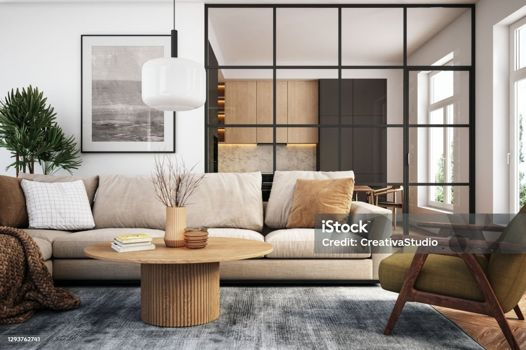


-------Response--------
The image showcases a stylish and contemporary living room, bathed in soft, natural light.  A plush, off-white sectional sofa anchors the space, inviting relaxation.  It is adorned with a mix of pillows in muted tones of white and burnt orange.  A sturdy, round coffee table, crafted from light wood with a slatted pedestal base, sits in front of the sofa, holding a stack of books and a decorative vase with dried florals. 

Behind the sofa, a striking black-framed glass partition wall subtly divides the living space from a modern kitchen.  The kitchen features warm, wood-toned cabinetry and sleek, dark countertops. The glimpse through the partition reveals glimpses of stainless steel appliances, adding to the modern aesthetic.

A large, abstract black and white artwork adorns the wall, adding a touch of artistic flair.  A leafy green plant in the corner introduces a touch of nature and vibrancy to the room. A contemporary green armchair with a wooden frame adds a

In [ ]:
# urls for room images
room_image_url = "https://media.istockphoto.com/id/1293762741/photo/modern-living-room-interior-3d-render.jpg?s=1024x1024&w=is&k=20&c=KJNOdrG3iN0AKdcQfg65atySC1HLFgbikY2DEAkJDPE="

# load room images as Image Objects
room_image = load_image_from_url(room_image_url)

prompt = "Describe what's visible in this room and the overall atmosphere:"
contents = [
    prompt,
    room_image,
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")


Generating open recommendations based on built-in knowledge


-------Prompt--------
Recommend a new piece of furniture for this room:


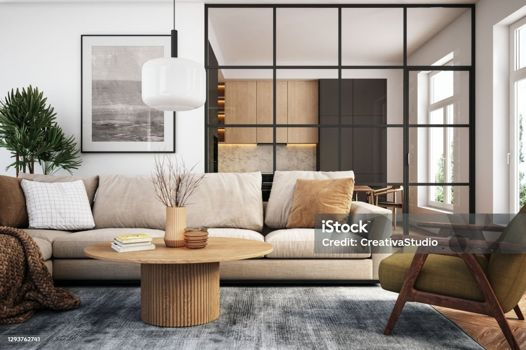

and explain the reason in detail

-------Response--------
The room needs a floor lamp. Here's why:

* **Balance:** The room has a strong horizontal presence with the large sofa and the grid-patterned wall. A tall floor lamp would introduce a vertical element, creating visual balance.
* **Lighting:**  The only visible light source is the pendant lamp, which likely provides focused light.  A floor lamp, ideally placed near the corner of the sofa or by the green chair, would add ambient lighting to the space, making it feel cozier in the evenings.
* **Style:** The existing furniture suggests a modern, slightly minimalist aesthetic with natural elements.  A floor lamp with clean lines and materials like wood or metal would complement this style. For example, an arc lamp with a marble base or a tripod lamp with a wooden shade would be excellent choices.

Adding a floor lamp would enhance the overall ambiance, functionality, and visual appeal of the room. 


In [ ]:
prompt1 = "Recommend a new piece of furniture for this room:"
prompt2 = "and explain the reason in detail"
contents = [prompt1, room_image, prompt2]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------
Describe this room:


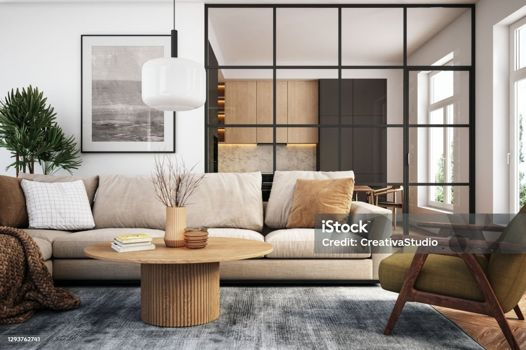

and recommend a colors for sofa that will match bohemian vibe

-------Response--------
The room is a modern living space with bohemian touches. Here's a breakdown:

**Key Features:**

* **Open Concept:** The living area flows seamlessly into a kitchen, divided by a sleek black-framed glass partition.
* **Neutral Palette:** The walls are crisp white, creating a bright and airy atmosphere.  This provides a neutral backdrop for pops of color and texture.
* **Natural Materials:** The room features wood furniture and floors, adding warmth and a connection to nature. A large potted plant further enhances this organic vibe.
* **Minimalist Design:** The furniture has clean lines and a simple aesthetic, characteristic of modern design. 

**Bohemian Accents:**

* **Textural Elements:** The throw pillows on the sofa feature a mix of textures, including a chunky knit blanket draped over the armrest.  This layering of textures is a key element of bohemian style. 
* **Natural Fiber Rug:** The rug on

In [ ]:
prompt1 = "Describe this room:"
prompt2 = "and recommend a colors for sofa that will match bohemian vibe"
contents = [prompt1, room_image, prompt2]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Product image background generation

In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [ ]:
PROJECT_ID = "inner-orb-434419-b6"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
from vertexai.generative_models import GenerativeModel, Image, Part

In [ ]:
model = GenerativeModel("gemini-1.5-pro-001")

In [ ]:
import typing
import http.client
import urllib.request
import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_image(
    image: Image,
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    pil_image = typing.cast(PIL_Image.Image, image._pil_image)
    if pil_image.mode != "RGB":
        # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
        pil_image = pil_image.convert("RGB")
    image_width, image_height = pil_image.size
    if max_width < image_width or max_height < image_height:
        # Resize to display a smaller notebook image
        pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
    IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def get_url_from_gcs(gcs_uri: str) -> str:
    # Converts GCS uri to url for image display
    url = "https://storage.googleapis.com/" + gcs_uri.replace("gs://", "").replace(
        " ", "%20"
    )
    return url

In [ ]:
# Load an image from Google Cloud Storage
gcs_uri = "gs://part-c-project/png-2702691_1280.png"
product_image = Part.from_uri(gcs_uri, mime_type="image/png")

# Display image
url = get_url_from_gcs(product_image.file_data.file_uri)
# IPython.display.Image(url, width=350)

In [ ]:
# Update the product description if using a different image
product_description = "a cat"  # @param {type:"string"}

prompt = """
Create a description of the product image.

The description should be an image generation prompt to create a more interesting background.

Only return the prompt string.
"""

contents = [product_image, product_description, prompt]

responses = model.generate_content(contents)
description = responses.text
print(description)

black and white cat on a psychedelic rainbow road
